# Raphaël extended edition - Director's Cut

Because there's never enough Raphaël, we will now data augment him.

In [35]:
import glob
import random
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

EXT_DATA = "../../data/external"

## Load the Raph

In [36]:
filenames = pd.read_csv("../../data/rawdata.csv")

In [37]:
display(filenames.head())

,Unnamed: 0,train_example,label
0,0,../../data/external/0.jpg,1
1,1,../../data/external/1.jpg,1
2,2,../../data/external/10.jpg,1
3,3,../../data/external/11.jpg,1
4,4,../../data/external/12.jpg,1


In [38]:
imgs = [plt.imread(f["train_example"], format="jpeg") for _, f in filenames.iterrows()]

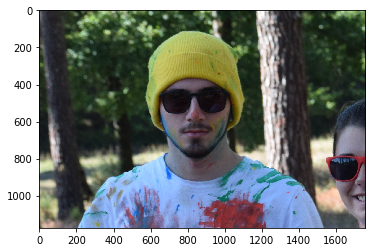

In [39]:
plt.imshow(imgs[0])

## Square and center the Raph

In [40]:
imgs[0].shape

(1174, 1761, 3)

In [41]:
size = min(imgs[0].shape[0:2])
print(f"Chosen min size: {size}")

Chosen min size: 1174


In [42]:
margin = (max(imgs[0].shape[0:2]) - size) // 2
print(f"Margin: {margin}")

Margin: 293


Shape: (1174, 1174, 3)


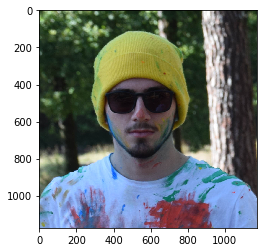

In [43]:
if np.array(imgs[0].shape).argmax() == 0:
    cropped = imgs[0][margin:margin+size,:,:]
else:
    cropped = imgs[0][:,margin:margin+size,:]
plt.imshow(cropped)   
print(f"Shape: {cropped.shape}")

In [44]:
cropped = []
for img in imgs:
    size = min(img.shape[0:2])
    margin = (max(img.shape[0:2]) - size) // 2
    if np.array(img.shape).argmax() == 0:
        cropped.append(Image.fromarray(img[margin:margin+size,:,:]).resize((128, 128), Image.ANTIALIAS))
    else:
        cropped.append(Image.fromarray(img[:,margin:margin+size,:]).resize((128, 128), Image.ANTIALIAS))

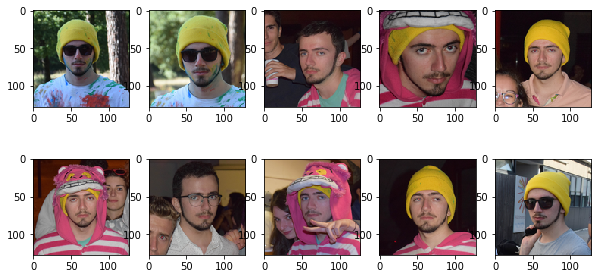

In [45]:
plt.figure(figsize=(10, 5))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(cropped[i-1])

In [46]:
for i, crop in enumerate(cropped):
    crop.convert("RGB").save(f"../../data/interim/{i}.png")

In [47]:
filenames = pd.DataFrame([[f"../../data/interim/{i}.png", 1] for i in range(len(cropped))], columns=["train_example", "label"])

In [48]:
display(filenames.head())
filenames.to_csv("../../data/interimdata.csv")

,train_example,label
0,../../data/interim/0.png,1
1,../../data/interim/1.png,1
2,../../data/interim/2.png,1
3,../../data/interim/3.png,1
4,../../data/interim/4.png,1


## Randomize the Raph

In [49]:
augmenter = ImageDataGenerator(
    brightness_range=[0.8, 1.5],
    rotation_range=20, 
    zoom_range=0.1, 
    fill_mode='reflect', 
    horizontal_flip=True, 
    dtype='float64')

In [50]:
filenames = pd.read_csv("../../data/interimdata.csv")
imgs = np.array([plt.imread(f["train_example"], format="jpeg") for _, f in filenames.iterrows()])

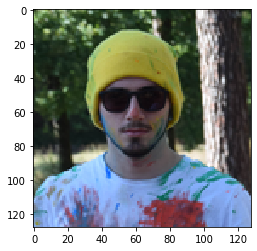

In [51]:
plt.imshow(imgs[0])

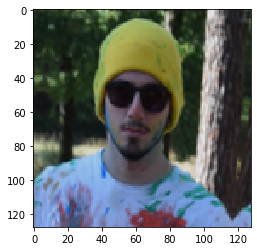

In [52]:
plt.imshow(augmenter.random_transform(imgs[0]).astype("uint8"))

In [59]:
augmented = []
for i in range(269):
    augmented.append(augmenter.random_transform(imgs[random.randint(0, len(imgs) - 1)]).astype("uint8"))

In [62]:
links = {
    "path": []
}

for i, img in enumerate(augmented):
    img_norm = img / 255
    np.save(f"../../data/processed/{i}", img_norm)
    links["path"].append(f"../../data/processed/{i}.npy")
for i, img in enumerate(imgs):
    img_norm = img / 255
    np.save(f"../../data/processed/{len(augmented)+i}", img)
    links["path"].append(f"../../data/processed/{len(augmented)+i}.npy")
    
with open("../../data/processed_data.json", "w+") as f:
    json.dump(links, f)